# AutoGluon Object Detection Tutorial

### Prerequisites

SageMaker Ground Truth로 레이블링 수행 완료 후 output.manifest를 로컬로 복사

![sagemaker-gt](./script/sagemaker-gt.png)

### References
- AutoGluon Multimodal - Quick Start: https://auto.gluon.ai/stable/tutorials/multimodal/multimodal_prediction/multimodal-quick-start.html

### Install packages

In [ ]:
!pip install -q autogluon==0.7.1b20230513

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import logging
import IPython
import importlib

#install_needed = True
install_needed = False

if install_needed:
    print("===> Installing deps and restarting kernel. Please change 'install_needed = False' and run this code cell again.")
    !{sys.executable} -m mim install mmcv-full==1.7.1
    !{sys.executable} -m pip install -q mmdet==2.28.2
    IPython.Application.instance().kernel.do_shutdown(True)

### Download dataset

You need to prepare your onw dataset

In [2]:
task = 'objdetection-pikachu'
!rm *.json
!rm -rf AutogluonModels tmp
!rm -rf {task} && mkdir -p {task}
!curl -L "https://universe.roboflow.com/ds/xZJGldQLjS?key=B56tyPNKRM" > roboflow.zip; unzip -q roboflow.zip -d {task}/images; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   884  100   884    0     0   5030      0 --:--:-- --:--:-- --:--:--  5051
100 1917k  100 1917k    0     0  6881k      0 --:--:-- --:--:-- --:--:-- 6881k


### Create Directory
AutoGluon MultiModalPredictor의 Object Detection은 아래와 같은 디렉토리로 설정하는 것을 추천
```
├── [YOUR-TASK-DIR]
│   ├── annotations: coco 포맷의 json annotation 파일이 위치한 경로
│   └── images: raw 이미지 경로
```

본 샘플 코드의 예시는 아래와 같다.
```
├── objdetection-pikachu
│   ├── annotations
│   └── images
│       ├── train
│       ├── valid
│       └── test
```


In [3]:
dataset_path = f"{task}/images"
annotations_path = f"{task}/annotations"
!mkdir -p {annotations_path}

### Convert SageMaker Ground Truth manifest file to COCO-formatted json file
- Step 1: SageMaker groundth truth의 manifest output 파일을 COCO 포맷으로 변환 (필요 시 utils.py 참조하여 수정할 것)
- Step 2: COCO 포맷 파일을 데이터셋 폴더로 복사

In [4]:
import shutil
from scripts.utils import convert_bbox_manifest, show_detection_result
dataset_type = ['train', 'valid', 'test']
json_path_dict = {}

for d in dataset_type:
    manifest_path = f"manifest/pikachu-{d}-output.manifest"
    job_name = f"objdetect-pikachu-gt-{d}-job"
    output_coco_json_path = f"{d}-coco.json"
    convert_bbox_manifest(manifest_path, job_name, output_coco_json_path, d)
    json_path = f"{annotations_path}/{output_coco_json_path}"
    shutil.copyfile(output_coco_json_path, json_path)
    json_path_dict[d] = json_path

train_path = json_path_dict['train']
valid_path = json_path_dict['valid']
test_path = json_path_dict['test']

print(train_path, valid_path, test_path)

objdetection-pikachu/annotations/train-coco.json objdetection-pikachu/annotations/valid-coco.json objdetection-pikachu/annotations/test-coco.json


https://github.com/open-mmlab/mmdetection/tree/master/configs/yolox

### Create MultiModalPredictor
- `problem_type="object_detection"` 으로 지정
- `sample_data_path`는 객체(object)의 범주를 파악하기 위해 필요하며 COCO 포맷 json에 명시되어 있음
- `model.mmdet_image.checkpoint_name`에서 객체 검출에 쓰일 모델 이름을 지정. 직접 모델을 지정하기 어렵다면 preset으로도 지정 가능 (예: `medium_quality, high_quality, best_quality`)

In [5]:
from autogluon.multimodal import MultiModalPredictor
# Init predictor
import uuid
#presets = "medium_quality"
checkpoint_name = "yolox_l_8x8_300e_coco"

model_path = f"./tmp/{uuid.uuid4().hex}-{task}-save"
predictor = MultiModalPredictor(
    hyperparameters={
        "model.mmdet_image.checkpoint_name": checkpoint_name,
        "optimization.val_metric": "map",
    },
    problem_type="object_detection",
    sample_data_path=train_path,
    #presets=presets,
    path=model_path
)

load checkpoint from local path: yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).
size mismatch for bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).
size mismatch for bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current mo

### Training
- More parameters: https://auto.gluon.ai/dev/tutorials/multimodal/advanced_topics/customization.html

In [6]:
import time
start = time.time()
predictor.fit(
    train_data=train_path,
    tuning_data=valid_path,
    hyperparameters={
        "optimization.learning_rate": 3e-5,
        "env.per_gpu_batch_size": 8,  # decrease it when model is large
        "optimization.max_epochs": 10,  # max number of training epochs, note that we may early stop before this based on validation setting
        "optimization.check_val_every_n_epoch": 2,  # Do k validation each 2 epochs
        "optimization.patience": 3,  # Early stop after k consective validations are not the best
    },
)  # Fit
end = time.time()
print("This finetuning takes %.2f seconds." % (end - start))

Using default root folder: objdetection-pikachu/annotations/... Specify `root=...` if you feel it is wrong...
Using default root folder: objdetection-pikachu/annotations/... Specify `root=...` if you feel it is wrong...
Global seed set to 0


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


AutoMM starts to create your model. ✨

- Model will be saved to "/home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save".

- Validation metric is "map".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_fl

Sanity Checking: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1, global step 2: 'val_map' reached 0.69081 (best 0.69081), saving model to '/home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save/epoch=1-step=2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 4: 'val_map' reached 0.87437 (best 0.87437), saving model to '/home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save/epoch=3-step=4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 6: 'val_map' reached 0.88772 (best 0.88772), saving model to '/home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save/epoch=5-step=6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 8: 'val_map' reached 0.92713 (best 0.92713), saving model to '/home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save/epoch=7-step=8.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 10: 'val_map' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/tmp/cc11d03b439a44e9a1b1aeb94bb1b13a-objdetection-pikachu-save
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




This finetuning takes 93.05 seconds.


### Evaluation

In [7]:
predictor.evaluate(valid_path)

Using default root folder: objdetection-pikachu/annotations/... Specify `root=...` if you feel it is wrong...
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: 0it [00:00, ?it/s]

A new predictor save path is created.This is to prevent you to overwrite previous predictor saved here.You could check current save path at predictor._save_path.If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20230517_004331/"


saving file at /home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/AutogluonModels/ag-20230517_004331/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.854
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 

{'map': 0.853832508250825,
 'mean_average_precision': 0.853832508250825,
 'map_50': 0.9336633663366335,
 'map_75': 0.9336633663366335,
 'map_small': -1.0,
 'map_medium': -1.0,
 'map_large': 0.853832508250825,
 'mar_1': 0.8949999999999999,
 'mar_10': 0.8949999999999999,
 'mar_100': 0.8949999999999999,
 'mar_small': -1.0,
 'mar_medium': -1.0,
 'mar_large': 0.8949999999999999}

### Prediction

In [8]:
from glob import glob
import numpy as np
test_path = f"{task}/images/test" 
test_files = glob(f'{test_path}/*.jpg') + glob(f'{test_path}/*.jpeg') + glob(f'{test_path}/*.png')

You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]

image     objdetection-pikachu/images/test/pikachu-1_jpg...
bboxes    [{'class': 'pikachu', 'bbox': [115.31979, 51.4...
Name: 0, dtype: object


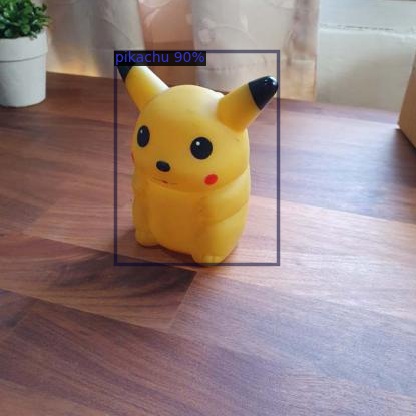

In [9]:
test_idx = np.random.randint(len(test_files))
img_path = test_files[test_idx]
img_result = predictor.predict(img_path).iloc[0]
print(img_result)
show_detection_result(img_path, img_result, 0.5)

### Save trained model

In [10]:
model_dir = "model"
predictor.save(model_dir, standalone=True)